<a href="https://colab.research.google.com/github/lilylydia/Android-CandyCodedApplication/blob/master/GNN_linkPrediction_SageConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install pyg-lib -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00


In [ ]:
#!pip install torch_geometric
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html

In [ ]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import numpy as np
import torch
from torch.nn import Linear
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader, DataLoader
from torch_geometric.nn import  to_hetero, GATConv, GCNConv #, SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
import torch
print(torch.__version__)

2.1.0+cu121


In [ ]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
cs_path = './charging_points_data.csv'
sessions_path = './sessions_data_21_23.csv'

In [ ]:
cs_df_1 = pd.read_csv(cs_path)
sessions_df_1 = pd.read_csv(sessions_path)
cs_df = cs_df_1[cs_df_1['charging_point'].isin(sessions_df_1['charging_point'])]
sessions_df = sessions_df_1[sessions_df_1['charging_point'].isin(cs_df_1['charging_point'])]

In [ ]:
cs_df['charging_point'].nunique()

135

In [ ]:
cs_ids = cs_df['charging_point'].unique()
cs_id_mapping = {id: idx for idx, id in enumerate(cs_ids)}
cs_df['charging_point'] = cs_df['charging_point'].map(cs_id_mapping)
cs_df.set_index('charging_point', inplace=True)
#scale dataset
sc = StandardScaler()
num_d = cs_df.select_dtypes(exclude=['object'])
cs_df[num_d.columns] = sc.fit_transform(num_d)
# Use type as cs input features:
cs_feat_1 = torch.from_numpy(cs_df['puissance_mean'].values).to(torch.float)
cs_feat_2 = torch.from_numpy(cs_df['Total energy consumption'].values).to(torch.float)
cs_feat_3 = torch.from_numpy(cs_df['Average charging duration'].values).to(torch.float)
cs_feat_4 = torch.from_numpy(cs_df['Average number of charging hourly'].values).to(torch.float)
cs_feat_5 = torch.from_numpy(cs_df['X'].values).to(torch.float)
cs_feat_6 = torch.from_numpy(cs_df['Y'].values).to(torch.float)
'''cs_feat_7 = torch.from_numpy(cs_df['convenience'].values).to(torch.float)
cs_feat_8 = torch.from_numpy(cs_df['finance'].values).to(torch.float)
cs_feat_9 = torch.from_numpy(cs_df['transportation'].values).to(torch.float)
cs_feat_10 = torch.from_numpy(cs_df['healthcare'].values).to(torch.float)
cs_feat_11 = torch.from_numpy(cs_df['education'].values).to(torch.float)
cs_feat_12 = torch.from_numpy(cs_df['government'].values).to(torch.float)
cs_feat_13 = torch.from_numpy(cs_df['recreation'].values).to(torch.float)
cs_feat_14 = torch.from_numpy(cs_df['services'].values).to(torch.float)
cs_feat_15 = torch.from_numpy(cs_df['religious'].values).to(torch.float)
cs_feat_16 = torch.from_numpy(cs_df['way'].values).to(torch.float)
cs_feat_17 = torch.from_numpy(cs_df['miscellaneous'].values).to(torch.float)'''
cs_feat_7 = torch.from_numpy(cs_df['nbrcon'].values).to(torch.float)
cs_feat_8 = torch.from_numpy(cs_df['overall_count'].values).to(torch.float)
cs_feat_9 = torch.from_numpy(cs_df['nb_sessions'].values).to(torch.float)

<ipython-input-52-25f5490fe550>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_df['charging_point'] = cs_df['charging_point'].map(cs_id_mapping)
<ipython-input-52-25f5490fe550>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_df[num_d.columns] = sc.fit_transform(num_d)


In [ ]:
#scale dataset
sc_user = StandardScaler()
num_d = sessions_df.select_dtypes(exclude=['object'])
sessions_df[num_d.columns] = sc_user.fit_transform(num_d)

unique_user_id = sessions_df['Auth id'].unique()
user_duration_y = sessions_df.groupby('Auth id')['duration_y'].apply(lambda x: list(set(x))).reset_index()
user_feats_duration = user_duration_y['duration_y'].apply(lambda x: torch.tensor(x, dtype=torch.float))

user_consumption = sessions_df.groupby('Auth id')['consumption_user'].apply(lambda x: list(set(x))).reset_index()
user_feats_consumption = user_consumption['consumption_user'].apply(lambda x: torch.tensor(x, dtype=torch.float))

#user_price = sessions_df.groupby('Auth id')['Price_y'].apply(lambda x: list(set(x))).reset_index()
#user_feats_price = user_price['Price_y'].apply(lambda x: torch.tensor(x, dtype=torch.float))

user_reference = sessions_df.groupby('Auth id')['Reference_y'].apply(lambda x: list(set(x))).reset_index()
user_feats_reference = user_reference['Reference_y'].apply(lambda x: torch.tensor(x, dtype=torch.float))

user_start_hour = sessions_df.groupby('Auth id')['start_hour'].apply(lambda x: list(set(x))).reset_index()
user_feats_start_hour = user_start_hour['start_hour'].apply(lambda x: torch.tensor(x, dtype=torch.float))

user_feat_1 = torch.cat(tuple(user_feats_duration))
user_feat_2 = torch.cat(tuple(user_feats_consumption))
user_feat_3 = torch.cat(tuple(user_feats_start_hour))
user_feat_4 = torch.cat(tuple(user_feats_reference))
#user_feat_5 = torch.cat(tuple(user_feats_price))

<ipython-input-53-f188115ff3db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_df[num_d.columns] = sc_user.fit_transform(num_d)


In [ ]:
torch.stack([user_feat_1,user_feat_2,user_feat_3,user_feat_4], dim=1)

tensor([[-0.4098, -0.3480, -0.9171, -0.9571],
        [-0.6873, -0.3854, -0.4372, -0.9484],
        [-0.7208,  1.3300,  0.4285, -0.9571],
        ...,
        [-0.4905,  1.3931, -0.5740, -0.8787],
        [-0.2751, -0.9369, -0.5072, -0.9746],
        [-0.7944, -0.9337,  0.3519, -0.9659]])

In [ ]:
user_feat_3.shape

torch.Size([11812])

In [ ]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = pd.DataFrame(data={
    'Auth id': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

Mapping of user IDs to consecutive values:
    Auth id  mappedID
0  9E7AE25B         0
1  8A410DDF         1
2  09D3BF01         2
3  E1A5C56E         3
4  8134F26E         4



In [ ]:
unique_user_id.shape

(11812, 2)

In [ ]:
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_cs_id = sessions_df['charging_point'].unique()
unique_cs_id = pd.DataFrame(data={
    'charging_point': unique_cs_id,
    'mappedID': pd.RangeIndex(len(unique_cs_id)),
})
print("Mapping of cs IDs to consecutive values:")
print("===========================================")
print(unique_cs_id.head())

Mapping of cs IDs to consecutive values:
  charging_point  mappedID
0           USZM         0
1           PKUU         1
2           MXEQ         2
3           WPGG         3
4           ACUK         4


In [ ]:
unique_cs_id.shape

(135, 2)

In [ ]:
# Perform merge to obtain the edges from users and movies:
sessions_user_id = pd.merge(sessions_df['Auth id'], unique_user_id,left_on='Auth id', right_on='Auth id', how='left')
sessions_user_id = torch.from_numpy(sessions_user_id['mappedID'].values)
sessions_cs_id = pd.merge(sessions_df['charging_point'], unique_cs_id, left_on='charging_point', right_on='charging_point', how='left')
sessions_cs_id = torch.from_numpy(sessions_cs_id['mappedID'].values)
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_cs = torch.stack([sessions_user_id, sessions_cs_id], dim=0)
print()
print("Final edge indices pointing from users to cs:")
print("========================")


Final edge indices pointing from users to cs:


In [ ]:
#features for edges
edge_feat_1 = torch.from_numpy(sessions_df['Consumption_session'].values).to(torch.float)
edge_feat_2 = torch.from_numpy(sessions_df['duration_x'].values).to(torch.float)
#edge_feat_3 = torch.from_numpy(sessions_df['Price_x'].values).to(torch.float)

edge_feat_1.shape

torch.Size([454078])

In [ ]:
data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["cs"].node_id = torch.arange(len(cs_df))
#add node features for cs nodes
data['user'].x = torch.stack([user_feat_1,user_feat_2,user_feat_3,user_feat_4], dim=1)
#add node features for cs nodes
cs_feats_list = []
for i in range(1, 9 + 1):
    cs_feat_var_name = f"cs_feat_{i}"
    cs_feat_tensor = locals()[cs_feat_var_name]  # Access the variable dynamically
    cs_feats_list.append(cs_feat_tensor)

data["cs"].x = torch.stack(cs_feats_list, dim=1)
# Add node features and edge indices:
data["user", "consumption", "cs"].edge_index = edge_index_user_to_cs
data["user", "consumption", "cs"].edge_attr  = torch.stack([edge_feat_1,edge_feat_2],dim=1)
# We also need to make sure to add the reverse edges from cs to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)
del data["cs", "rev_consumption", "user"].edge_label  # Remove "reverse" label
del data["cs", "rev_consumption", "user"].edge_attr  # Remove "reverse" attr

In [ ]:
data['cs'].x.shape

torch.Size([135, 9])

In [ ]:
#If data[key] in RandomLinkSplit does not exist, it will be automatically created
#and represents a binary classification task (1 = edge, 0 = no edge)
#Si add_negative_train_samples est défini sur False, le modèle suppose que l'échantillonnage négatif est déjà géré ailleurs dans le processus d'entraînemen
#neg_sampling_ratio=1.0, # 1.0 means number of negative edges in the training is equal to nbr of positive edges #in our case there is a lot of neg edges so we reduce neg_sampl_ratio == 0.0
transform = T.RandomLinkSplit(
    num_val=0.2,
    num_test=0.2,
    disjoint_train_ratio=0.3, #30% of the training edges are not shared for message passing and supervision
    neg_sampling_ratio= 0.7, # sampling negative edges at a ratio of 0.5 compared to positive edges during training.
    add_negative_train_samples=True,
    edge_types=("user", "consumption", "cs"),
    rev_edge_types=None,
)
train_data, val_data, test_data = transform(data)

In [ ]:
test_data["user", "consumption", "cs"].edge_label.unique()

tensor([0., 1.])

In [ ]:
for ii in train_loader:
  print(ii["user", "consumption", "cs"].edge_label.unique())

In [ ]:
edge_label = train_data["user", "consumption", "cs"].edge_attr
edge_label.shape

torch.Size([190714, 2])

In [ ]:
# Define seed edges Train data:
edge_label_index = train_data["user", "consumption", "cs"].edge_label_index
edge_label = train_data["user", "consumption", "cs"].edge_label
train_loader =  LinkNeighborLoader(
    data=train_data,
    num_neighbors=[25, 10],
    #neg_sampling_ratio=2.0,
    edge_label_index=(("user", "consumption", "cs"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,)
# Define the validation seed edges:
edge_label_index = val_data["user", "consumption", "cs"].edge_label_index
edge_label = val_data["user", "consumption", "cs"].edge_label

val_loader =  LinkNeighborLoader(
    data=val_data,
    num_neighbors=[25, 10],
    edge_label_index=(("user", "consumption", "cs"), edge_label_index),
    edge_label=edge_label,
    batch_size= 128,
    shuffle=False,)

In [ ]:
from typing import List, Optional, Tuple, Union
import torch.nn.functional as F
from torch import Tensor

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size, SparseTensor
from torch_geometric.utils import spmm

class SAGEConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: Optional[Union[str, List[str], Aggregation]] = "mean",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == 'lstm':
            kwargs.setdefault('aggr_kwargs', {})
            kwargs['aggr_kwargs'].setdefault('in_channels', in_channels[0])
            kwargs['aggr_kwargs'].setdefault('out_channels', in_channels[0])

        super().__init__(aggr, **kwargs)

        if self.project:
            if in_channels[0] <= 0:
                raise ValueError(f"'{self.__class__.__name__}' does not "
                                 f"support lazy initialization with "
                                 f"`project=True`")
            self.lin = Linear(in_channels[0], in_channels[0], bias=True)

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(
                in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        self.lin_l = Linear(aggr_out_channels + 2, out_channels, bias=bias) #2: nbr features of edges
        self.lin_l_node_only = Linear(aggr_out_channels , out_channels, bias=bias) # For cases without edge_attr
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        if self.project:
            self.lin.reset_parameters()
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(
        self,
        x: Union[Tensor, OptPairTensor],
        edge_index: Adj,
        edge_attr,
        size: Size = None,
    ) -> Tensor:
        # Ensure x is a pair tensor
        x: OptPairTensor = (x, x) if isinstance(x, Tensor) else x

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return  out

    def message(self, x_j, edge_attr):
      #if edge_attr is None (for edges with 0 l label we dont cosnider this info)
      if edge_attr is not None:
        return self.lin_l(torch.cat([x_j, edge_attr], dim=-1))
      else:
        return self.lin_l_node_only(x_j)

    def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
        if isinstance(adj_t, SparseTensor):
            adj_t = adj_t.set_value(None, layout=None)
        return spmm(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.convs.append(torch.nn.BatchNorm1d(hidden_channels))
            self.convs.append(torch.nn.Dropout(p=0.5))  # Added dropout after batchnorm

    def forward(self, x, edge_index, edge_attr):
        for i in range(0, len(self.convs), 3):
            x = F.relu(self.convs[i+1](self.convs[i](x, edge_index, edge_attr)))
            x = self.convs[i+2](x)  # Apply dropout
        return x

class Classifier(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=0.5)  # Added dropout

    def forward(self, x_user, x_cs, edge_label_index):
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_cs = x_cs[edge_label_index[1]]
        z = edge_feat_user * edge_feat_cs
        z = F.relu(self.lin1(z))  # Added non-linearity
        z = self.dropout(z)  # Apply dropout
        z = self.lin2(z).sum(dim=-1)
        z = torch.sigmoid(z).squeeze(-1) #remove last dimension
        return z

class Model(torch.nn.Module):
    def __init__(self, hidden_channels,num_layers):
        super().__init__()
        self.cs_lin = torch.nn.Linear(9, hidden_channels)
        self.user_lin = torch.nn.Linear(4,hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.cs_emb = torch.nn.Embedding(data["cs"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels,num_layers)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier(hidden_channels)
    def forward(self, data: HeteroData) -> torch.Tensor:
        x_dict = {
          "user": self.user_lin(data['user'].x) + self.user_emb(data["user"].node_id),
          "cs": self.cs_lin(data["cs"].x) + self.cs_emb(data["cs"].node_id),
        }
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["cs"],
            data["user", "consumption", "cs"].edge_label_index,
        )
        return pred

Device: 'cuda'


/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Epoch: 001, Loss: 0.3903, Val Loss: 0.2032
Epoch: 002, Loss: 0.2335, Val Loss: 0.1546
Epoch: 003, Loss: 0.1991, Val Loss: 0.1382
Epoch: 004, Loss: 0.1805, Val Loss: 0.1260
Epoch: 005, Loss: 0.1646, Val Loss: 0.1161
Epoch: 006, Loss: 0.1555, Val Loss: 0.1096
Epoch: 007, Loss: 0.1473, Val Loss: 0.1071
Epoch: 008, Loss: 0.1391, Val Loss: 0.1069
Epoch: 009, Loss: 0.1348, Val Loss: 0.1061


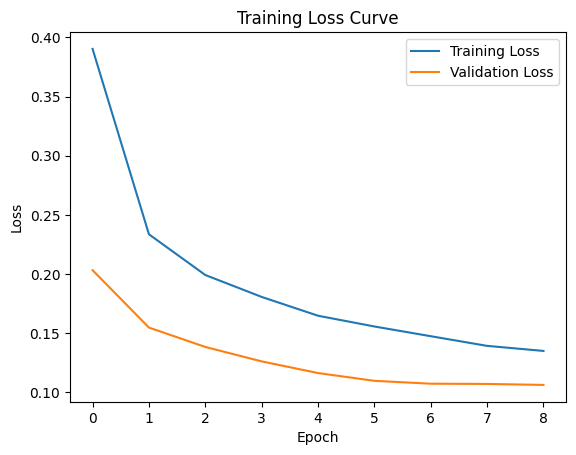

In [ ]:
train_losses = []
val_losses=[]
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = Model(hidden_channels=128,num_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 10):
    model.train()
    total_loss = total_examples = 0
    for sampled_data in train_loader:
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "consumption", "cs"].edge_label
        loss = F.binary_cross_entropy(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    #avg loss for epoch
    avg_loss =  total_loss / total_examples
    train_losses.append(avg_loss)

    #validation
    model.eval()
    total_val_loss = total_val_examples = 0
    with torch.no_grad():
      for val_data in val_loader:
        val_data.to(device)
        val_pred = model(val_data)
        val_ground_truth = val_data["user", "consumption", "cs"].edge_label
        val_loss = F.binary_cross_entropy(val_pred, val_ground_truth)
        total_val_loss += float(val_loss) * val_pred.numel()
        total_val_examples +=val_pred.numel()
    avg_val_loss = total_val_loss / total_val_examples
    val_losses.append(avg_val_loss)
    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # reset counter if there is an improvement
        torch.save(model.state_dict(), './model_link_pred_SageConv.pth')  # save the best model
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break  # Break the loop if the patience has been reached

    print(f"Epoch: {epoch:03d}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


model.load_state_dict(torch.load('./model_link_pred_SageConv.pth'))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
torch.nn.Embedding(sampled_data["user"].num_nodes, 32)

Embedding(977, 32)

In [ ]:
# Define the test seed edges:
edge_label_index = test_data["user", "consumption", "cs"].edge_label_index
edge_label = test_data["user", "consumption", "cs"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[25, 10],
    edge_label_index=(("user", "consumption", "cs"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)
sampled_data = next(iter(test_loader))

In [ ]:
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)

        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "consumption", "cs"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

binary_predictions = (pred > 0.5).astype(int)
auc = roc_auc_score(ground_truth, pred)
accuracy = accuracy_score(ground_truth, binary_predictions)
recall = recall_score(ground_truth, binary_predictions)
precision = precision_score(ground_truth, binary_predictions)

print(f"\nTest AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 1207/1207 [00:19<00:00, 63.36it/s] 



Test AUC: 0.9933
Accuracy: 0.9619
Recall: 0.9773
Precision: 0.9587


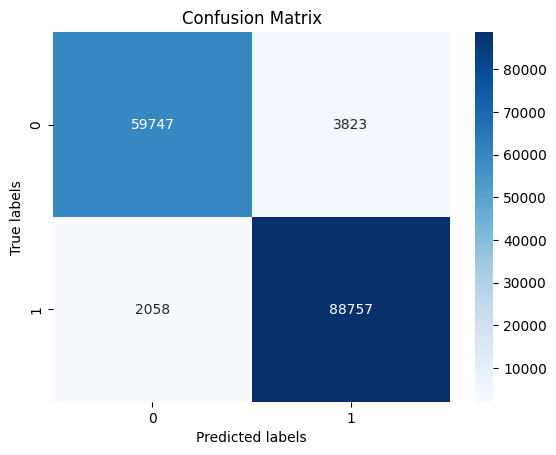

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(ground_truth, binary_predictions)

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(ground_truth, binary_predictions).ravel()
fpr = fp / (fp + tn)
print("False Positive Rate:", fpr)

False Positive Rate: 0.06013843007708038


In [ ]:
sessions_df['Auth id'].nunique()

11812

In [ ]:
test_data["user", "consumption", "cs"].edge_label_index

tensor([[3450, 7525, 2158,  ..., 6754, 3274, 2129],
        [  39,  122,  116,  ...,  109,   64,   72]])

In [ ]:
edge_label_index = test_data["user", "consumption", "cs"].edge_label_index.numpy()
filtered_array = edge_label_index[:, edge_label_index[0] == 1309]
indices = np.where(edge_label_index[0] == 1309)[0]
indices

array([ 42723,  98455, 108292, 127549, 130957, 132214, 139223, 143546,
       146657])

In [ ]:
filtered_array

array([[1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309, 1309],
       [  10,  112,   36,   22,   18,   49,   46,   45,   27]])

In [ ]:
#np.unique(filtered_array[0])
predictions_user = []
ground_truth_user = []
for i in indices:
  predictions_user.append(pred[i])
  ground_truth_user.append(ground_truth[i])
print(predictions_user)
print(ground_truth_user)

[0.93732, 0.10288419, 0.0007310741, 0.05689581, 0.01588221, 0.008741367, 0.04744864, 0.06512437, 0.0023383542]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
unique_user_id[unique_user_id['Auth id'] == 'FR-FRM-CSU2AQG7N']['mappedID']

Series([], Name: mappedID, dtype: int64)

In [ ]:
sessions_df[sessions_df['Auth id'] == 'FR-FRM-CSU2AQG7N']['charging_point'].value_counts()

Series([], Name: charging_point, dtype: int64)

In [ ]:
indices = []
for couple in edge_index_user_to_cs.numpy().T:
    index = np.where((edge_label_index[0] == couple[0]) & (edge_label_index[1] == couple[1]))
    if len(index[0]) > 0:
        indices.append(index[0][0])
    else:
        indices.append(None)
print(indices)

In [ ]:
'''def get_user_features(user_id):
    user_features = torch.stack([
        user_feat_1[unique_user_id[unique_user_id['Auth id'] == user_id]['mappedID'].index],
        user_feat_2[unique_user_id[unique_user_id['Auth id'] == user_id]['mappedID'].index],
        user_feat_3[unique_user_id[unique_user_id['Auth id'] == user_id]['mappedID'].index],
        user_feat_4[unique_user_id[unique_user_id['Auth id'] == user_id]['mappedID'].index],
        user_feat_5[unique_user_id[unique_user_id['Auth id'] == user_id]['mappedID'].index]
    ], dim=0).to(device)
    return user_features
def get_cs_features(cs_id):
cs_features = torch.stack([
    cs_feat_1[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_2[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_3[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_4[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_5[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_6[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
    cs_feat_7[unique_cs_id[unique_cs_id['charging_point'] == cs_id]['mappedID']],
], dim=0).to(device)
return cs_features
#reverse scaling:
#sessions_df[num_d.columns] = sc_user.inverse_transform(sessions_df[num_d.columns])
sessions_user_id = pd.merge(sessions_df[sessions_df['Auth id'] == 'FR-FRM-CSU2AQG7N'] , unique_user_id,left_on='Auth id', right_on='Auth id', how='left')
sessions_user_id = torch.from_numpy(sessions_user_id['mappedID'].values)
sessions_cs_id = pd.merge(sessions_df[sessions_df['Auth id'] == 'FR-FRM-CSU2AQG7N']['charging_point'], unique_cs_id, left_on='charging_point', right_on='charging_point', how='left')
sessions_cs_id =  torch.from_numpy(sessions_cs_id['mappedID'].values)
edge_index_user_to_cs = torch.stack([sessions_user_id, sessions_cs_id], dim=0)'''

**Deuxième modèle avec Encoder-Decoder** GATConv

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels,heads=1, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels,add_self_loops=False)
        self.batchnorm = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(0.6)
    def forward(self, x, edge_index,edge_attr):
        x = self.conv1(x, edge_index,edge_attr)
        x = self.batchnorm(x)
        x = self.dropout(x).relu()
        x = self.conv2(x, edge_index,edge_attr)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear( hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.6)
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = z_dict['user'][row] * z_dict['cs'][col]
        z = F.relu(self.lin1(z))
        z = self.dropout(z)
        z = self.lin2(z)
        z = torch.sigmoid(z).squeeze(-1) #remove last dimension
        return z

class Model_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.cs_lin = torch.nn.Linear(9, hidden_channels)
        self.user_lin = torch.nn.Linear(4,hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.cs_emb = torch.nn.Embedding(data["cs"].num_nodes, hidden_channels)

        self.encoder = GNNEncoder(hidden_channels,  hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, data: HeteroData, edge_index_dict, edge_label_index,edge_attr_dict):
        data.x_dict['user'] = self.user_lin(data['user'].x) + self.user_emb(data['user'].node_id)
        data.x_dict['cs'] = self.cs_lin(data['cs'].x) + self.cs_emb(data['cs'].node_id)
        z_dict = self.encoder(data.x_dict, edge_index_dict,edge_attr_dict)
        return self.decoder(z_dict, edge_label_index)

Epoch: 001, Loss: 0.7211, Val Loss: 0.5979
Epoch: 002, Loss: 0.7213, Val Loss: 0.5993
Epoch: 003, Loss: 0.7172, Val Loss: 0.6006
Epoch: 004, Loss: 0.7181, Val Loss: 0.6020
Epoch: 005, Loss: 0.7161, Val Loss: 0.6035
Epoch: 006, Loss: 0.7138, Val Loss: 0.6050
Epoch: 007, Loss: 0.7155, Val Loss: 0.6066
Epoch: 008, Loss: 0.7158, Val Loss: 0.6083
Epoch: 009, Loss: 0.7143, Val Loss: 0.6100
Epoch: 010, Loss: 0.7088, Val Loss: 0.6118
Early stopping triggered


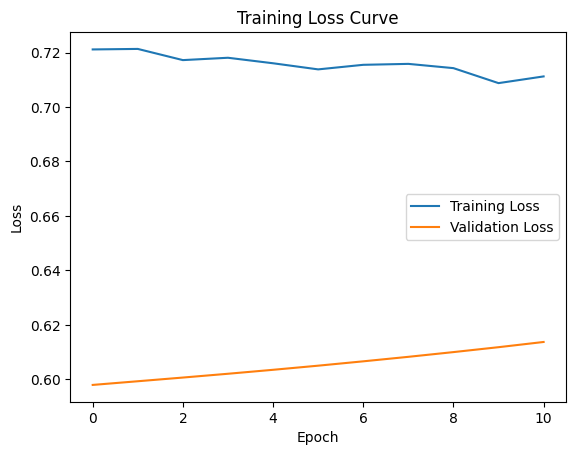

In [ ]:
model_2 = Model_2(hidden_channels=23).to(device)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

train_losses = []
val_losses=[]
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
for epoch in range(1, 600):
    train_data.to(device)
    total_loss = total_examples = 0
    model_2.train()
    optimizer_2.zero_grad()
    pred = model_2(train_data, train_data.edge_index_dict, train_data['user', 'cs'].edge_label_index,train_data.edge_attr_dict)
    ground_truth = train_data['user', 'cs'].edge_label
    loss = F.binary_cross_entropy(pred, ground_truth)
    loss.backward()
    optimizer_2.step()
    total_loss += float(loss) * pred.numel()
    total_examples += pred.numel()
    #avg loss for epoch
    avg_loss =  total_loss / total_examples
    train_losses.append(avg_loss)
    #validation
    model_2.eval()
    total_val_loss = total_val_examples = 0
    with torch.no_grad():
      val_data.to(device)
      val_pred = model_2(val_data, val_data.edge_index_dict, val_data['user', 'cs'].edge_label_index,val_data.edge_attr_dict)
      val_ground_truth = val_data['user', 'cs'].edge_label
      val_loss = F.binary_cross_entropy(val_pred, val_ground_truth)
      total_val_loss += float(val_loss) * val_pred.numel()
      total_val_examples +=val_pred.numel()
    avg_val_loss = total_val_loss / total_val_examples
    val_losses.append(avg_val_loss)
    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0  # reset counter if there is an improvement
        torch.save(model.state_dict(), './model_link_pred_SageConv.pth')  # save the best model
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break  # Break the loop if the patience has been reached

    print(f"Epoch: {epoch:03d}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), './model_link_pred_GAT.pth')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
preds = []
ground_truths = []
with torch.no_grad():
    test_data.to(device)
    preds.append(model_2(test_data, test_data.edge_index_dict, test_data['user', 'cs'].edge_label_index,test_data.edge_attr_dict))
    ground_truths.append(test_data['user', 'cs'].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

binary_predictions = (pred > 0.5).astype(int)
auc = roc_auc_score(ground_truth, pred)
accuracy = accuracy_score(ground_truth, binary_predictions)
recall = recall_score(ground_truth, binary_predictions)
precision = precision_score(ground_truth, binary_predictions)

print(f"\nTest AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Test AUC: 0.5612
Accuracy: 0.4117
Recall: 0.0000
Precision: 0.0000


In [ ]:
!pip install pulp
!pip install osmnx

**Generate Data (locations of users (vehciles) and charging stations)**

In [20]:
import random
import numpy as np
import osmnx as ox

city_bounds = {'min_lat': 3.1531, 'max_lat': 3.6694, 'min_lon':  47.7652, 'max_lon':48.2320} #Auxerre
vehicles_data = [
    {"model": "Nissan Leaf", "battery_capacity_kWh": 39},
    {"model": "Tesla Model 3 Long Range Dual Motor", "battery_capacity_kWh": 75},
    {"model": "Hyundai IONIQ 5 Long Range 2WD", "battery_capacity_kWh": 74},
    {"model": "Hyundai Kona Electric", "battery_capacity_kWh": 65.4},
    {"model": "BMW iX3", "battery_capacity_kWh": 74},
    {"model": "Mercedes-Benz EQS 450 4MATIC", "battery_capacity_kWh": 108.4},
    {"model": "Renault Twingo Electric", "battery_capacity_kWh": 21.3},
    {"model": "Porsche Taycan Turbo", "battery_capacity_kWh": 97},
    {"model": "Audi SQ6 e-tron", "battery_capacity_kWh": 94.9},
    {"model": "Volkswagen ID.4 GTX", "battery_capacity_kWh": 77},]

charging_stations = [{'lat':47.79613 , 'lon': 3.56364}, {'lat': 47.86908, 'lon': 3.45092},
                      {'lat': 47.94329,  'lon': 3.48604}, {'lat': 47.80642,  'lon': 3.63664},
                      {'lat': 47.95174,  'lon': 3.43875},
                      ]
average_efficiency_km_per_kWh = 6.5 #une approximation
# Constants for conversion
meters_per_degree_lat = 111320
meters_per_degree_lon = 85000  # Approximation at latitude ~48 degrees
radius_meters = 500  # The radius within which we want to generate vehicle locations

# Convert radius to degrees
radius_lat = radius_meters / meters_per_degree_lat
radius_lon = radius_meters / meters_per_degree_lon
def simulated_vehicles_around_stations(vehicles_data,charging_stations,radius_lat,radius_lon):
  for vehicle in vehicles_data:
      vehicle['max_distance_km'] = vehicle['battery_capacity_kWh'] * average_efficiency_km_per_kWh
  simulated_vehicles = []
  for station in charging_stations:
      chosen_vehicle = random.choice(vehicles_data)
      lat_offset = random.uniform(-radius_lat, radius_lat)
      lon_offset = random.uniform(-radius_lon, radius_lon)
      new_lat = station['lat'] + lat_offset
      new_lon = station['lon'] + lon_offset
      for _ in range(2):
        vehicle_simulation = {
            'model': chosen_vehicle['model'],
            'lat': new_lat,
            'lon': new_lon,
            'SoC': random.uniform(10, 50),  # Assuming SoC is between 20% and 80%
            'max_distance_km': chosen_vehicle['max_distance_km'] * (random.uniform(10, 50) / 100.0)  # Adjust max_distance based on SoC
        }
        simulated_vehicles.append(vehicle_simulation)
  return simulated_vehicles
simulated_vehicles = simulated_vehicles_around_stations(vehicles_data,charging_stations,radius_lat,radius_lon)

In [23]:
print(simulated_vehicles)

[{'model': 'Tesla Model 3 Long Range Dual Motor', 'lat': 47.792157278874264, 'lon': 3.5680698866383067, 'SoC': 37.39030336324964, 'max_distance_km': 180.4697209131263}, {'model': 'Tesla Model 3 Long Range Dual Motor', 'lat': 47.792157278874264, 'lon': 3.5680698866383067, 'SoC': 47.66036067282306, 'max_distance_km': 209.642238033313}, {'model': 'Audi SQ6 e-tron', 'lat': 47.871523363969175, 'lon': 3.4469598787078817, 'SoC': 30.599033098601044, 'max_distance_km': 173.139832619949}, {'model': 'Audi SQ6 e-tron', 'lat': 47.871523363969175, 'lon': 3.4469598787078817, 'SoC': 43.453131038925, 'max_distance_km': 212.5402921307436}, {'model': 'Renault Twingo Electric', 'lat': 47.940911834399124, 'lon': 3.481239792305705, 'SoC': 18.58576666300822, 'max_distance_km': 29.818488096130295}, {'model': 'Renault Twingo Electric', 'lat': 47.940911834399124, 'lon': 3.481239792305705, 'SoC': 37.41829806734427, 'max_distance_km': 41.470583503199755}, {'model': 'Volkswagen ID.4 GTX', 'lat': 47.805280878831184

In [6]:
G = ox.graph_from_place('Yonne, France', network_type='drive')
#ox.plot_graph(G)

In [ ]:
def nearest_node_stations(charging_stations,G):
  for station in charging_stations:
    station['station_st_node_id'] = ox.distance.nearest_nodes(G, [station['lon']], [station['lat']])[0]
    print(station)
def nearest_node_vehicles(simulated_vehicles,G):
  for vehicle in simulated_vehicles:
    vehicle['vehicle_st_node_id'] = ox.distance.nearest_nodes(G, [vehicle['lon']], [vehicle['lat']])[0]
    print(vehicle)
nearest_node_stations(charging_stations,G)
nearest_node_vehicles(simulated_vehicles,G)

In [ ]:
import networkx as nx
def calculate_travel_time(simulated_vehicles,charging_stations,G):
  travel_times = {}
  i = 0
  for vehicle in simulated_vehicles:
    j = 0
    for station in charging_stations:
        travel_time =  nx.shortest_path_length(G, vehicle['vehicle_st_node_id'], station['station_st_node_id'], weight='time')
        travel_times[i , j] = travel_time
        j = j+1
    i = i + 1
  return travel_times
travel_times = calculate_travel_time(simulated_vehicles,charging_stations,G)
travel_times

### **Autre methode**

In [26]:
import pulp

num_users = 10
num_stations = 4
time_steps = [10, 20, 30, 40, 50, 60]  # time steps in minutes

'''travel_times = {
    (0, 0): 15, (0, 1): 25, (0, 2): 35,
    (1, 0): 10, (1, 1): 20, (1, 2): 30,
    (2, 0): 20, (2, 1): 10, (2, 2): 25
}'''

availability = {
    'Station0': {10: 1, 20: 1, 30: 0, 40: 0, 50: 0, 60: 0},
    'Station1': {10: 0, 20: 1, 30: 1, 40: 1, 50: 1, 60: 1},
    'Station2': {10: 0, 20: 0, 30: 1, 40: 1, 50: 1, 60: 1},
    'Station3': {10: 1, 20: 1, 30: 1, 40: 0, 50: 0, 60: 0}
}

In [27]:
def random_heuristic_assignment(users, stations, travel_times, availability):
    # Assign users randomly to stations
    assignments = {}
    for user in range(users):
        # Select a random station for each user
        assigned_station = random.randint(0, stations - 1)
        assignments[user] = assigned_station

    return assignments

def nearest_heuristic_assignment(users, stations, travel_times, availability):
    # Assign users to the nearest station based on travel time
    assignments = {}
    for user in range(users):
        min_travel_time = float('inf')
        assigned_station = None
        for station in range(stations):
            if travel_times[(user, station)] < min_travel_time:
                min_travel_time = travel_times[(user, station)]
                assigned_station = station
        assignments[user] = assigned_station
    return assignments

def calculate_wait_time_for_assignment(users, stations, travel_times, availability,assignments):
    # Convert availability to a more manageable format
    station_avail = {i: [] for i in range(stations)}
    for station, times in availability.items():
        station_index = int(station[-1])   # Convert 'Station1' to 0 index
        for time, avail in times.items():
            if avail == 0:  # 0 means free
                station_avail[station_index].append(time)

    # Sort availability times for each station
    for station in station_avail:
        station_avail[station].sort()

    # Step 2: Calculate waiting times
    waiting_times = {}
    total_time = {}
    station_next_free_time = {station: 0 for station in range(stations)}
    for user, station in assignments.items():
        travel_time = travel_times[(user, station)]
        # Find the next available time that is after the user's travel time
        available_times = [time for time in station_avail[station] if time >= station_next_free_time[station]]
        if not available_times:
            assigned_time = 0 #station_next_free_time[station]
            total_time[user] = 0
        else:
            assigned_time = available_times[0] #assign to the first avialble time

            waiting_time = max(0, assigned_time - travel_time)
            waiting_times[user] = travel_time + waiting_time
            total_time[user] = waiting_times[user] + travel_time
            station_next_free_time[station] = assigned_time + 10

    return assignments, total_time

random_assignment = random_heuristic_assignment(num_users, num_stations, travel_times, availability)
random_assignment, random_total_time = calculate_wait_time_for_assignment(num_users, num_stations, travel_times, availability,random_assignment)
nearest_assignments = nearest_heuristic_assignment(num_users, num_stations, travel_times, availability)
nearest_assignments, nearest_total_time = calculate_wait_time_for_assignment(num_users, num_stations, travel_times, availability,nearest_assignments)
print('\n Nearest Station assignements----------')
for user, station in nearest_assignments.items():
    print(f"User {user} assigned to Station {station } total waiting time is {nearest_total_time[user]}")
print('\n Random assignements----------')
for user, station in random_assignment.items():
    print(f"User {user} assigned to Station {station } total waiting time is {random_total_time[user]}")


 Nearest Station assignements----------
User 0 assigned to Station 0 total waiting time is 37
User 1 assigned to Station 0 total waiting time is 47
User 2 assigned to Station 1 total waiting time is 13
User 3 assigned to Station 1 total waiting time is 0
User 4 assigned to Station 2 total waiting time is 16
User 5 assigned to Station 2 total waiting time is 26
User 6 assigned to Station 3 total waiting time is 45
User 7 assigned to Station 3 total waiting time is 55
User 8 assigned to Station 2 total waiting time is 0
User 9 assigned to Station 2 total waiting time is 0

 Random assignements----------
User 0 assigned to Station 3 total waiting time is 84
User 1 assigned to Station 2 total waiting time is 108
User 2 assigned to Station 2 total waiting time is 50
User 3 assigned to Station 0 total waiting time is 76
User 4 assigned to Station 2 total waiting time is 0
User 5 assigned to Station 1 total waiting time is 40
User 6 assigned to Station 2 total waiting time is 0
User 7 assign

In [62]:
def MILP_assignement(num_users,num_stations,availability,time_steps,travel_times):
  model = pulp.LpProblem("Charging_Station_Assignment", pulp.LpMinimize)
  # X[u][s][t] = 1 if user 'u' is assigned to station 's' at time 't'
  X = pulp.LpVariable.dicts("X", ((u, s, t) for u in range(num_users)
                                        for s in range(num_stations)
                                        for t in time_steps), cat='Binary')
  # Define a variable for waiting time for simplicity, although not directly used in constraints
  W = pulp.LpVariable.dicts("W", (u for u in range(num_users)), lowBound=0, cat='Continuous')
  model += pulp.lpSum([W[u] for u in range(num_users)])
  # Constraint 1: Each user is assigned to one station and one time step only
  for u in range(num_users):
      model += pulp.lpSum([X[u, s, t] for s in range(num_stations) for t in time_steps]) == 1

  # Constraint 2: A station can serve only one user at a time step
  for s in range(num_stations):
      for t in time_steps:
          model += pulp.lpSum([X[u, s, t] for u in range(num_users)]) <= (0 if availability[f'Station{s}'][t] == 1 else 1)

  # Constraint 3: Incorporate travel times and availability
  for u in range(num_users):
      for s in range(num_stations):
          for t in time_steps:
              # If user arrives before the time step, they can be considered for assignment
              arrival_time = travel_times[(u, s)]
              model += X[u, s, t] == 0 if arrival_time > t else X[u, s, t]

  model.solve()
  lp_waiting_times = {}
  print('\n MILP assignements----------')
  for u in range(num_users):
      for s in range(num_stations):
          for t in time_steps:
              if pulp.value(X[u, s, t]) == 1:
                  lp_waiting_times[u] = t + travel_times[(u, s)]
                  print(f"User {u} assigned to Station {s} at time {t} minutes, waiting time is {t + travel_times[(u, s)]}")
  return lp_waiting_times
lp_waiting_times = MILP_assignement(num_users,num_stations,availability,time_steps,travel_times)


 MILP assignements----------
User 0 assigned to Station 0 at time 60 minutes, waiting time is 67
User 1 assigned to Station 0 at time 30 minutes, waiting time is 37
User 2 assigned to Station 0 at time 40 minutes, waiting time is 78
User 3 assigned to Station 1 at time 10 minutes, waiting time is 13
User 4 assigned to Station 2 at time 10 minutes, waiting time is 16
User 5 assigned to Station 3 at time 50 minutes, waiting time is 97
User 6 assigned to Station 3 at time 40 minutes, waiting time is 45
User 7 assigned to Station 0 at time 50 minutes, waiting time is 94
User 8 assigned to Station 3 at time 60 minutes, waiting time is 114
User 9 assigned to Station 2 at time 20 minutes, waiting time is 37


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1675: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [63]:
print("User Waiting Times Comparison:")
print("User\tRandom\tHeuristic\tLP")
for user in range(num_users):
    heuristic_time = nearest_total_time[user] if nearest_total_time[user] is not None else "No Assignment"
    random_time = random_total_time[user] if random_total_time[user] is not None else "No Assignment"
    lp_time = lp_waiting_times.get(user, "No Assignment")
    print(f"{user}\t{random_time}\t\t{heuristic_time}\t{lp_time}")


User Waiting Times Comparison:
User	Random	Heuristic	LP
0	84		37	67
1	108		47	37
2	50		13	78
3	76		0	13
4	0		16	16
5	40		26	97
6	0		45	45
7	88		55	94
8	106		0	114
9	113		0	37


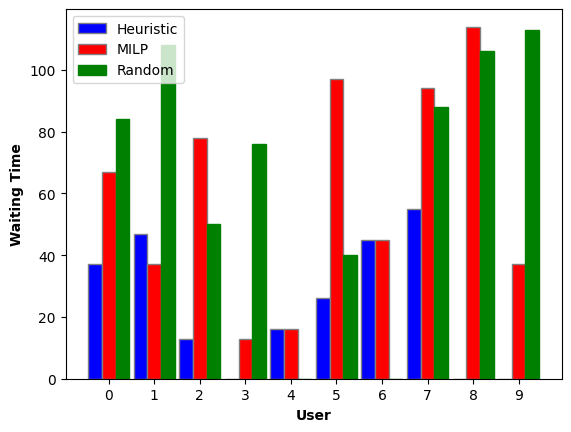

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these dictionaries filled with waiting times for each user
heuristic_waiting_times = nearest_total_time  # Replace with actual data
# Ensure all users are represented, even if one method has no assignment for them
all_users = sorted(set(heuristic_waiting_times.keys()).union(set(lp_waiting_times.keys())))

# Gather data for plotting
heuristic_times = [heuristic_waiting_times.get(user, 0) for user in all_users]
lp_times = [lp_waiting_times.get(user, 0) for user in all_users]
random_time = [random_total_time.get(user, 0) for user in all_users]
# Define the plot
fig, ax = plt.subplots()

# Set position of bar on X axis
barWidth = 0.3
r1 = np.arange(len(all_users))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax.bar(r1, heuristic_times, color='b', width=barWidth, edgecolor='grey', label='Heuristic')
ax.bar(r2, lp_times, color='r', width=barWidth, edgecolor='grey', label='MILP')
ax.bar(r3, random_time, color='g', width=barWidth, edgecolor='green', label='Random')

# Add xticks on the middle of the group bars
ax.set_xlabel('User', fontweight='bold')
ax.set_ylabel('Waiting Time', fontweight='bold')
ax.set_xticks([r + barWidth for r in range(len(all_users))])
ax.set_xticklabels(all_users)

# Create legend & Show graphic
ax.legend()
plt.show()

**Deuxième scénario**

In [ ]:
num_users = 10
num_stations = 4
time_steps = [10, 20, 30, 40, 50, 60]  # time steps in minutes

'''travel_times = {
    (0, 0): 15, (0, 1): 25, (0, 2): 35,
    (1, 0): 10, (1, 1): 20, (1, 2): 30,
    (2, 0): 20, (2, 1): 10, (2, 2): 25
}'''

availability = {
    'Station0': {10: 1, 20: 1, 30: 0, 40: 0, 50: 0, 60: 0},
    'Station1': {10: 0, 20: 1, 30: 1, 40: 1, 50: 1, 60: 1},
    'Station2': {10: 0, 20: 0, 30: 1, 40: 1, 50: 1, 60: 1},
    'Station3': {10: 1, 20: 1, 30: 1, 40: 0, 50: 0, 60: 0}
}

charging_stations = [{'lat':47.79613 , 'lon': 3.56364}, {'lat': 47.86908, 'lon': 3.45092},
                      {'lat': 47.94329,  'lon': 3.48604}, {'lat': 47.80642,  'lon': 3.63664},
                      {'lat': 47.95174,  'lon': 3.43875},
                      ]
average_efficiency_km_per_kWh = 6.5 #une approximation
# Constants for conversion
meters_per_degree_lat = 111320
meters_per_degree_lon = 85000  # Approximation at latitude ~48 degrees
radius_meters = 500  # The radius within which we want to generate vehicle locations

**Genetic Algorithm**

In [61]:
import random
import numpy as np

def evaluate_fitness(individual, travel_times, availability, time_steps):
    total_wait_time = 0
    station_time_allocations = {s: list(time_steps) for s in range(num_stations)}  # Track available time slots

    for user, station in enumerate(individual):
        travel_time = travel_times[(user, station)]
        # Find the next available time slot
        available_times = station_time_allocations[station]
        assigned_time = None
        for time in available_times:
            if time >= travel_time:  # Considering travel time
                assigned_time = time
                break
        if assigned_time is not None:
            wait_time = assigned_time - travel_time
            total_wait_time += wait_time
            station_time_allocations[station].remove(assigned_time)  # Allocate time slot, remove from availability
        else:
            total_wait_time += 10000  # Apply penalty for users who cannot be assigned

    return 1 / (1 + total_wait_time)  # Fitness function

def generate_population(size, num_users, num_stations):
    return [random.choices(range(num_stations), k=num_users) for _ in range(size)]

def select_parents(population, fitnesses, num_parents):
    parents = random.choices(population, weights=fitnesses, k=num_parents)
    return parents

def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(child, num_stations, mutation_rate=0.1):
    if random.random() < mutation_rate:
        index = random.randint(0, len(child) - 1)
        child[index] = random.randint(0, num_stations - 1)
    return child

def genetic_algorithm(travel_times, availability, time_steps, num_generations=100, population_size=50, num_parents=10, mutation_rate=0.1):
    population = generate_population(population_size, num_users, num_stations)
    for generation in range(num_generations):
        fitnesses = [evaluate_fitness(individual, travel_times, availability, time_steps) for individual in population]
        new_population = []
        for _ in range(population_size // 2):
            parents = select_parents(population, fitnesses, 2)
            child1, child2 = crossover(parents[0], parents[1])
            child1 = mutate(child1, num_stations, mutation_rate)
            child2 = mutate(child2, num_stations, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population
    # Return the best solution
    best_fitness = max(fitnesses)
    best_index = fitnesses.index(best_fitness)
    return population[best_index]

best_solution = genetic_algorithm(travel_times, availability, time_steps)
print("Best Solution:", best_solution)


Best Solution: [0, 1, 0, 3, 1, 2, 1, 2, 1, 2]


In [59]:
# Adjusted Function to Calculate Waiting Times for Each User
def calculate_individual_waiting_times(individual, travel_times, availability, time_steps):
    user_waiting_times = []
    for i, station in enumerate(individual):
        travel_time = travel_times.get((i, station), float('inf'))
        waiting_time = 0
        for time in time_steps:
            if availability[f'Station{station}'][time] == 0:  # Station is free
                if time >= travel_time:  # User arrives before or at the time station becomes available
                    waiting_time = max(0, time - travel_time)

                break
            if time == time_steps[-1]:  # User couldn't be assigned within the given time steps
                waiting_time = float('inf')
        user_waiting_times.append((station, travel_time, waiting_time))
    return user_waiting_times

# Function to Print Detailed Assignment and Waiting Times
def print_user_assignments_and_waiting_times(best_solution, travel_times, availability, time_steps):
    user_details = calculate_individual_waiting_times(best_solution, travel_times, availability, time_steps)
    print("User | Assigned Station | Travel Time | Waiting Time")
    print("-----------------------------------------------------")
    for user, (station, travel_time, waiting_time) in enumerate(user_details):
        total_waiting_time = travel_time + waiting_time if waiting_time != float('inf') else "Not Assignable"
        print(f"{user}    | {station}               | {travel_time}         | {total_waiting_time}")

# Example: Running the GA and printing the results
best_solution = genetic_algorithm(travel_times, availability, time_steps)
print("Best Solution:", best_solution)
print_user_assignments_and_waiting_times(best_solution, travel_times, availability, time_steps)


Best Solution: [0, 1, 3, 0, 1, 0, 2, 1, 0, 1]
23
User | Assigned Station | Travel Time | Waiting Time
-----------------------------------------------------
0    | 0               | 7         | 30
1    | 1               | 44         | 44
2    | 3               | 48         | 48
3    | 0               | 38         | 38
4    | 1               | 20         | 20
5    | 0               | 45         | 45
6    | 2               | 47         | 47
7    | 1               | 39         | 39
8    | 0               | 53         | 53
9    | 1               | 26         | 26
